# $t-J$ model MPO $vs$ Exact Diagonalization

Let us form the $t-J$ model in its different pieces

$$ H_{t-J} = H_{Heis} + H_t + H_{holes} $$
$$ H_{Heis} = J_z \sum_i S_i^z S_{i+1}^z + \frac{J_{\perp}}{2} \sum_i \left( S_i^+ S_{i+1}^- + S_i^- S_{i+1}^+ \right) $$
$$ H_t = \sum_{\sigma =\uparrow , \downarrow} t_{\sigma} \sum_i \left( a_{i, \sigma}^\dagger a_{i+1, h}^\dagger a_{i, h} a_{i+1, \sigma} + a_{i, h}^\dagger a_{i+1, \sigma}^\dagger a_{i, \sigma} a_{i+1, h} \right)$$
$$ H_{holes} = V \sum_i n_{i,h} n_{i+1,h} \quad \mathrm{with} \quad n_{i,h} = a_{i,h}^\dagger a_{i,h} $$

In [1]:
%load_ext autoreload
%autoreload 2

import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import numpy as np

from scipy.sparse import identity, csc_array, csc_matrix, kron
from qs_mps.sparse_hamiltonians_and_operators import diagonalization

import matplotlib.pyplot as plt

# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 13
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

## Exact Diagonalization

### Construction

Let's start with an operator in the Heisenberg hamiltonian to find the most efficient way of building the operators

In [3]:
# Sz
def sparse_S_z(i, n):
    diag = [[1]*(3**(n+1 - (i+1))) + [0]*(3**(n+1 - (i+1))) + [-1]*(3**(n+1 - (i+1)))]*(3**(i - 1))
    return diag

In [4]:
S_z = csc_matrix([[1,0,0],[0,0,0],[0,0,-1]])
Id = csc_matrix([[1,0,0],[0,1,0],[0,0,1]])

In [5]:
diag = sparse_S_z(i=3, n=3)
np.array(diag).flatten()

array([ 1,  0, -1,  1,  0, -1,  1,  0, -1,  1,  0, -1,  1,  0, -1,  1,  0,
       -1,  1,  0, -1,  1,  0, -1,  1,  0, -1])

In [6]:
mat = kron(kron(S_z, Id), Id).toarray()
# mat = kron(kron(Id, S_z), Id).toarray()
mat = kron(kron(Id, Id), S_z).toarray()
[mat[i,i] for i in range(3**3)]

[np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1)]

In [7]:
def kron_sparse_S_z(i, n):
    if (i > 1) and (i < n):
        left = Id
        right = Id
        for k in range(1,i-1):
            left = kron(left, Id)
        for k in range(i+1,n):
            right = kron(Id, right)
        return kron(kron(left,S_z),right)
    elif i == 1:
        right = Id
        for k in range(i+1,n):
            right = kron(Id, right)
        return kron(S_z,right)
    elif i == n:
        left = Id
        for k in range(1,i-1):
            left = kron(left, Id)        
        return kron(left, S_z)

In [8]:
i, n = 3, 3
mat = kron_sparse_S_z(i, n).toarray()
[mat[k,k] for k in range(3**n)]

[np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1),
 np.int64(1),
 np.int64(0),
 np.int64(-1)]

In [9]:
diag = sparse_S_z(i=3, n=3)
csc_matrix(np.array(diag).flatten(), shape=(3**n,3**n))

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 18 stored elements and shape (27, 27)>

In [10]:
def Sz_sparse(i, n, dtype=np.int8):
    """
    Sparse S_z operator acting on site i (1-based indexing)
    for n qutrits (up=1, hole=0, down=-1).
    Returns a 3**n x 3**n sparse CSR matrix.
    """
    block = 3 ** (n - i)
    repeats = 3 ** (i - 1)

    diag = np.empty(3**n, dtype=dtype)
    pattern = np.array([1, 0, -1], dtype=dtype)

    diag.reshape(repeats, 3, block)[:] = pattern[:, None]

    return sp.diags(diag, format="csr")

Sz = sp.diags([1, 0, -1], 0, format="csr")
I  = sp.identity(3, format="csr")
def Sz_sparse_kron(i, n):
    left  = sp.identity(3**(i-1), format="csr")
    right = sp.identity(3**(n-i), format="csr")

    return sp.kron(sp.kron(left, Sz, format="csr"), right, format="csr")

In [11]:
%%timeit
i, n = 3, 15
kron_sparse_S_z(i, n)

33.6 ms ± 716 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
i, n = 3, 15
diag = sparse_S_z(i=i, n=n)
csc_matrix(np.array(diag).flatten(), shape=(3**n,3**n))

430 ms ± 4.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
i, n = 3, 15
Sz_sparse(i, n)

118 ms ± 964 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
i, n = 3, 15
Sz_sparse_kron(i, n)

64 ms ± 320 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


For large number of particles $n$ the faster function is the kroneker product approach `kron_sparse_S_z()`

Let us now define the operators left

### Exact Hamiltonian

In [ ]:
# Single-site identity
Id = sp.identity(3, format="csr")

# Spin operators
Sz = (1/2) * sp.diags([1, 0, -1], 0, format="csr")
S_plus  = sp.csr_matrix([[0, 0, 1],
                          [0, 0, 0],
                          [0, 0, 0]])

S_minus = sp.csr_matrix([[0, 0, 0],
                          [0, 0, 0],
                          [1, 0, 0]])

# Hole hopping operators

# spin up goes into a hole state
T_up_h   = sp.csr_matrix([[0, 1, 0],
                           [0, 0, 0],
                           [0, 0, 0]])

# spin down goes into a hole state
T_down_h = sp.csr_matrix([[0, 0, 0],
                           [0, 0, 0],
                           [0, 1, 0]])

# hole goes into a spin up state
T_h_up   = sp.csr_matrix([[0, 0, 0],
                           [1, 0, 0],
                           [0, 0, 0]])

# hole goes into a spin down state
T_h_down = sp.csr_matrix([[0, 0, 0],
                           [0, 0, 1],
                           [0, 0, 0]])

# Hole number operator
n_h = sp.csr_matrix([[0, 0, 0],
                      [0, 1, 0],
                      [0, 0, 0]])

ops = [Sz, S_plus, S_minus, T_h_up, T_h_down, T_up_h, T_down_h, n_h]

In [31]:
def kron_sparse_op(Op, i, n):
    if (i > 1) and (i < n):
        left = Id
        right = Id
        for k in range(1,i-1):
            left = kron(left, Id)
        for k in range(i+1,n):
            right = kron(Id, right)
        return kron(kron(left,Op),right)
    elif i == 1:
        right = Id
        for k in range(i+1,n):
            right = kron(Id, right)
        return kron(Op,right)
    elif i == n:
        left = Id
        for k in range(1,i-1):
            left = kron(left, Id)        
        return kron(left, Op)


def total_magnetization(n):
    M = sp.csr_matrix((3**n, 3**n))
    for i in range(1, n+1):
        M += kron_sparse_op(2*Sz, i, n)
    return M/n

def staggered_total_magnetization(n):
    M = sp.csr_matrix((3**n, 3**n))
    for i in range(1, n+1):
        if (i % 2) == 0:
            M -= kron_sparse_op(2*Sz, i, n)
        elif (i % 2) == 1:
            M += kron_sparse_op(2*Sz, i, n)
    return M

In [10]:
# Heisenberg ham
def heis_ham(n, Jz, J_perp, eps):
    # zz-int
    H_zz = sp.csr_matrix((3**n,3**n))
    if Jz != 0:
        for i in range(1,n):
            H_zz += kron_sparse_op(Sz,i,n) @ kron_sparse_op(Sz,i+1,n)
    
    # pm-int
    H_pm = sp.csr_matrix((3**n,3**n))
    if J_perp != 0:
        for i in range(1,n):
            H_pm += kron_sparse_op(S_plus,i,n) @ kron_sparse_op(S_minus,i+1,n)
    
    # pm-int
    H_mp = sp.csr_matrix((3**n,3**n))
    if J_perp != 0:
        for i in range(1,n):
            H_mp += kron_sparse_op(S_minus,i,n) @ kron_sparse_op(S_plus,i+1,n)
    
    # breaking degeneracy (if eps<0 -> up, if eps>0 -> down)
    H_z = sp.csr_matrix((3**n,3**n))
    if eps != 0:
        for i in range(1,n+1):
            H_z += kron_sparse_op(Sz,i,n)

    return Jz * H_zz + (J_perp / 2) * (H_pm + H_mp) + eps * H_z

# hopping ham
def hop_ham(n, t_up, t_down):
    # up-hole
    H_uh = sp.csr_matrix((3**n,3**n))
    if t_up != 0:
        for i in range(1,n-1):
            H_uh += kron_sparse_op(T_up_h,i,n) @ kron_sparse_op(T_h_up,i+1,n)

    # hole-up
    H_hu = sp.csr_matrix((3**n,3**n))
    if t_up != 0:
        for i in range(1,n-1):
            H_hu += kron_sparse_op(T_h_up,i,n) @ kron_sparse_op(T_up_h,i+1,n)
    
    # up-hole
    H_dh = sp.csr_matrix((3**n,3**n))
    if t_down != 0:
        for i in range(1,n-1):
            H_dh += kron_sparse_op(T_down_h,i,n) @ kron_sparse_op(T_h_down,i+1,n)

    # hole-down
    H_hd = sp.csr_matrix((3**n,3**n))
    if t_down != 0:
        for i in range(1,n-1):
            H_hd += kron_sparse_op(T_h_down,i,n) @ kron_sparse_op(T_down_h,i+1,n)
    

    return - t_up * (H_uh + H_hu) - t_down * (H_dh + H_hd)

# holes ham
def hol_ham(n, V):
    # zz-int
    H_hh = sp.csr_matrix((3**n,3**n))
    if V != 0:
        for i in range(1,n-1):
            H_hh += kron_sparse_op(n_h,i,n) @ kron_sparse_op(n_h,i+1,n)
    
    return V * H_hh

def tJV_ham(n, t_up, t_down, Jz, J_perp, eps, V):
    H_t = hop_ham(n=n, t_up=t_up, t_down=t_down)
    H_J = heis_ham(n=n, Jz=Jz, J_perp=J_perp, eps=eps)
    H_V = hol_ham(n=n, V=V)

    return H_t + H_J + H_V

In [199]:
n = 3
t_up = 1
t_down = 1
Jz = 1
J_perp = 1
V = 1
U_h = 1

H_tJV = tJV_ham(n, t_up, t_down, Jz, J_perp, V, U_h)

### Heisenberg test

In [6]:
up = np.array([1,0,0])
down = np.array([0,0,1])

def guess_state_neel(n):
    guess = up.copy()
    for i in range(1,n):
        if (i % 2) == 0:
            guess = kron(guess, up)
        elif (i % 2) == 1:
            guess = kron(guess, down)
    return guess

def guess_state_ferro(n):
    guess = up.copy()
    for i in range(1,n):
        guess = kron(guess, up)
    return guess

hole = np.array([[0,1,0]]).T
up = np.array([[1,0,0]]).T
down = np.array([[0,0,1]]).T

def guess_state_hole(n, holes=-1):
    if holes == -1:
        guess = hole.copy()
        for i in range(1,n):
            guess = kron(guess, hole)
    else:
        if holes == 1:
            guess = hole.copy()
            for i in range(1,n):
                guess = kron(guess, down)
    return guess

In [29]:
state = guess_state_neel(n=5)
# state = guess_state_ferro(n=5)
M = total_magnetization(n=5)
M_s = staggered_total_magnetization(n=5)

(state.conjugate().T @ M @ state).data, (state.conjugate().T @ M_s @ state).data

(array([0.2]), array([1.]))

In [87]:
N = 8
Jz = -10
eps = 0
state = guess_state_neel(n=N).toarray()
M_s = staggered_total_magnetization(n=N)
M = total_magnetization(n=N)
H_heis = heis_ham(n=N, Jz=Jz, J_perp=1, eps=eps)
# e, vec = diagonalization(H_heis, sparse=False, which="LM")
e, vec = diagonalization(H_heis, sparse=True, which="SA", k=10, v0=state)
psi = vec[:, 0]
print(psi.T.conjugate() @ M_s @ psi, e)
print(-(N-1)/4*Jz + N/4 * eps, -(N-1)/4*Jz + (N+1)/4 * eps)

0.010025063585587142 [-12.52506282 -12.52506282  -7.57507307  -7.57507275  -7.57505352
  -7.57505319  -7.55025096  -7.55025091  -3.37663128  -3.37663128]
17.5 17.5


In [ ]:
state.conjugate().T @ kron_sparse_op(S_plus,1,N) @ kron_sparse_op(S_minus,2,N) @ state
state_flipped = (kron_sparse_op(S_minus,1,N) @ kron_sparse_op(S_plus,2,N) + kron_sparse_op(S_plus,1,N) @ kron_sparse_op(S_minus,2,N)) @ state   

In [83]:
for i in range(1,N+1):
    print(state_flipped.conjugate().T @ kron_sparse_op(2*Sz,i,N) @ state_flipped, state.conjugate().T @ kron_sparse_op(2*Sz,i,N) @ state)

[[-1.]] [[1.]]
[[1.]] [[-1.]]
[[1.]] [[1.]]
[[-1.]] [[-1.]]
[[1.]] [[1.]]
[[-1.]] [[-1.]]
[[1.]] [[1.]]
[[-1.]] [[-1.]]


In [202]:
Jzs_n = np.linspace(-1.5,0,50)
Jzs_p = np.linspace(0,1.5,50)
# Js = np.logspace(1,-0.2,50)
J = 1
U_h = 0
n = 8
M_n = total_magnetization(n=n)
M_rms = M_n @ M_n
M_p = staggered_total_magnetization(n=n)
guess_state_p = guess_state_neel(n=n).toarray()
guess_state_n = guess_state_ferro(n=n).toarray()

energies = []

mag_n = []
for Jz in Jzs_n:
    print(f"J: {Jz:.3f}")
    H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=U_h)
    # e, vec = diagonalization(H_heis, sparse=False, which="LM")
    e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_n)
    psi = vec[:, 0]
    mag_n.append(psi.T.conjugate() @ M_n @ psi)
    energies.append(e)
    
    guess_state_n = psi.copy()

mag_p = []
for Jz in Jzs_p:
    print(f"J: {Jz:.3f}")
    H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=U_h)
    # e, vec = diagonalization(H_heis, sparse=False, which="LM")
    e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_p)
    psi = vec[:, 0]
    mag_p.append(psi.T.conjugate() @ M_p @ psi)
    energies.append(e)

    guess_state_p = psi.copy()

J: -1.500
J: -1.469
J: -1.439
J: -1.408
J: -1.378
J: -1.347
J: -1.316
J: -1.286
J: -1.255
J: -1.224
J: -1.194
J: -1.163
J: -1.133
J: -1.102
J: -1.071
J: -1.041
J: -1.010
J: -0.980
J: -0.949
J: -0.918
J: -0.888
J: -0.857
J: -0.827
J: -0.796
J: -0.765
J: -0.735
J: -0.704
J: -0.673
J: -0.643
J: -0.612
J: -0.582
J: -0.551
J: -0.520
J: -0.490
J: -0.459
J: -0.429
J: -0.398
J: -0.367
J: -0.337
J: -0.306
J: -0.276
J: -0.245
J: -0.214
J: -0.184
J: -0.153
J: -0.122
J: -0.092
J: -0.061
J: -0.031
J: 0.000
J: 0.000
J: 0.031
J: 0.061
J: 0.092
J: 0.122
J: 0.153
J: 0.184
J: 0.214
J: 0.245
J: 0.276
J: 0.306
J: 0.337
J: 0.367
J: 0.398
J: 0.429
J: 0.459
J: 0.490
J: 0.520
J: 0.551
J: 0.582
J: 0.612
J: 0.643
J: 0.673
J: 0.704
J: 0.735
J: 0.765
J: 0.796
J: 0.827
J: 0.857
J: 0.888
J: 0.918
J: 0.949
J: 0.980
J: 1.010
J: 1.041
J: 1.071
J: 1.102
J: 1.133
J: 1.163
J: 1.194
J: 1.224
J: 1.255
J: 1.286
J: 1.316
J: 1.347
J: 1.378
J: 1.408
J: 1.439
J: 1.469
J: 1.500


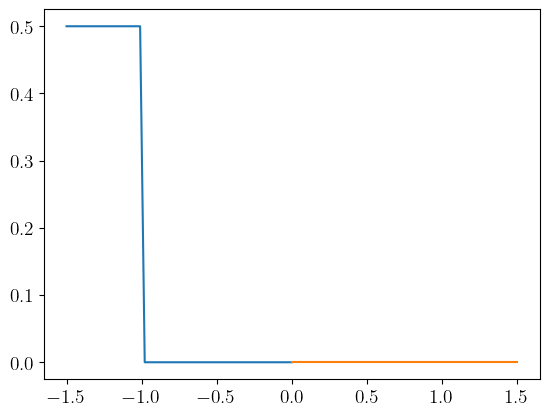

In [130]:
plt.plot(Jzs_n/J, mag_n)
plt.plot(Jzs_p/J, mag_p)

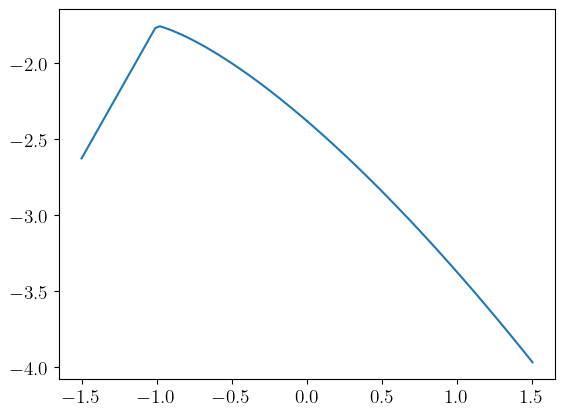

In [131]:
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energies)

In [236]:
energies = []
magnetizations = []
smagnetizations = []
h_i = -1.5
h_f = -1.5 
Jzs_n = np.linspace(-1.5,0,50)
Jzs_p = np.linspace(0,1.5,50)
npoints = len(Jzs_n.tolist() + Jzs_p.tolist())
Jzs = np.linspace(-1.5,1.5,101)
U_h = 0
Ns = [8]
for n in Ns:
    energies_N = []
    mag_N = []
    smag_N = []
    
    guess_state_p = guess_state_neel(n=n).toarray()
    guess_state_n = guess_state_ferro(n=n).toarray()
    M_n = total_magnetization(n=n)
    M_rms = M_n @ M_n
    M_p = staggered_total_magnetization(n=n)
    M_stag_rms = M_p @ M_p

    # for Jz in Jzs:
    #     print(f"N: {n}, J: {Jz:.3f}")
    #     H_heis = heis_ham(n=n, Jz=Jz, J_perp=J)
    #     # e, vec = diagonalization(H_heis, sparse=False, which="LM")
    #     e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_n)
    #     psi = vec[:, 0]
    #     mag_N.append((psi.T.conjugate() @ M_rms @ psi).real)
    #     smag_N.append((psi.T.conjugate() @ M_stag_rms @ psi).real)
    #     energies_N.append(e)

    #     guess_state_n = psi.copy()
        
    for Jz in Jzs_n:
        print(f"N: {n}, J: {Jz:.3f}")
        H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=U_h)
        e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_n)
        psi = vec[:, 0]
        mag_N.append((psi.T.conjugate() @ M_rms @ psi).real)
        smag_N.append((psi.T.conjugate() @ M_stag_rms @ psi).real)
        energies_N.append(e)
        
        guess_state_n = psi.copy()

    for Jz in Jzs_p:
        print(f"N: {n}, J: {Jz:.3f}")
        H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=U_h)
        e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_p)
        psi = vec[:, 0]
        mag_N.append((psi.T.conjugate() @ M_rms @ psi).real)
        smag_N.append((psi.T.conjugate() @ M_stag_rms @ psi).real)
        energies_N.append(e)

        guess_state_p = psi.copy()

    magnetizations.append(mag_N)
    smagnetizations.append(smag_N)

    energies.append(energies_N)

N: 8, J: -1.500
N: 8, J: -1.469
N: 8, J: -1.439
N: 8, J: -1.408
N: 8, J: -1.378
N: 8, J: -1.347
N: 8, J: -1.316
N: 8, J: -1.286
N: 8, J: -1.255
N: 8, J: -1.224
N: 8, J: -1.194
N: 8, J: -1.163
N: 8, J: -1.133
N: 8, J: -1.102
N: 8, J: -1.071
N: 8, J: -1.041
N: 8, J: -1.010
N: 8, J: -0.980
N: 8, J: -0.949
N: 8, J: -0.918
N: 8, J: -0.888
N: 8, J: -0.857
N: 8, J: -0.827
N: 8, J: -0.796
N: 8, J: -0.765
N: 8, J: -0.735
N: 8, J: -0.704
N: 8, J: -0.673
N: 8, J: -0.643
N: 8, J: -0.612
N: 8, J: -0.582
N: 8, J: -0.551
N: 8, J: -0.520
N: 8, J: -0.490
N: 8, J: -0.459
N: 8, J: -0.429
N: 8, J: -0.398
N: 8, J: -0.367
N: 8, J: -0.337
N: 8, J: -0.306
N: 8, J: -0.276
N: 8, J: -0.245
N: 8, J: -0.214
N: 8, J: -0.184
N: 8, J: -0.153
N: 8, J: -0.122
N: 8, J: -0.092
N: 8, J: -0.061
N: 8, J: -0.031
N: 8, J: 0.000
N: 8, J: 0.000
N: 8, J: 0.031
N: 8, J: 0.061
N: 8, J: 0.092
N: 8, J: 0.122
N: 8, J: 0.153
N: 8, J: 0.184
N: 8, J: 0.214
N: 8, J: 0.245
N: 8, J: 0.276
N: 8, J: 0.306
N: 8, J: 0.337
N: 8, J: 0.367
N: 8, 

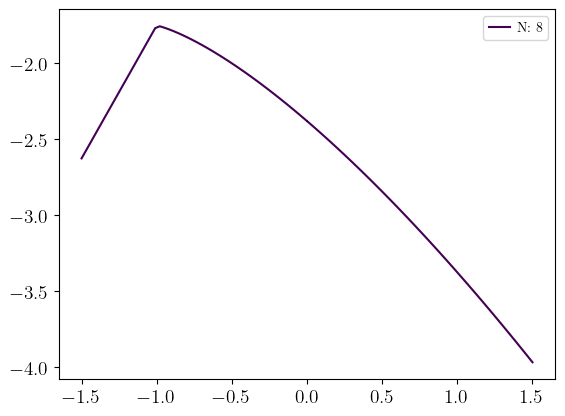

In [204]:
from qs_mps.utils import create_sequential_colors

colors = create_sequential_colors(len(Ns))

for i, energy in enumerate(energies):
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energy, color=colors[i], label=f"N: {Ns[i]}")
    # plt.plot(Jzs, energy, color=colors[i], label=f"N: {Ns[i]}")

plt.legend()

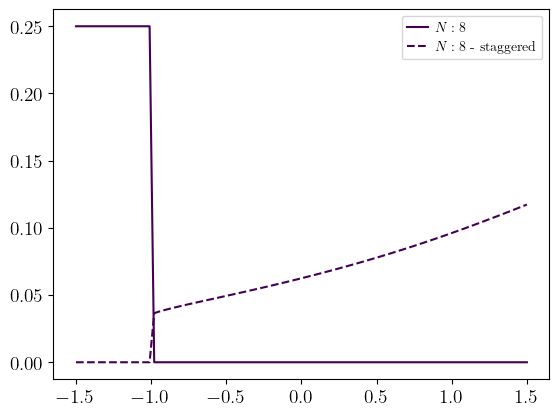

In [205]:
i = 0
for magnetization, smagnetization in zip(magnetizations, smagnetizations):
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), magnetization, color=colors[i], label=f"$N: {Ns[i]}$")
    # plt.plot(Jzs, magnetization, color=colors[i], label=f"$N: {Ns[i]}$")
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), smagnetization, linestyle='--', color=colors[i], label=f"$N: {Ns[i]}$ - staggered")
    # plt.plot(Jzs, smagnetization, linestyle='--', color=colors[i], label=f"$N: {Ns[i]}$ - staggered")
    i += 1

plt.legend()

## MPO

In [66]:
from qs_mps.mps_class import MPS

N = 8
mps = MPS(L=N, d=3, model="heis", chi=100, J=1, h=-1.5, eps=10)

In [67]:
from qs_mps.utils import tensor_shapes

mps.mpo()
tensor_shapes(mps.w)

(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)
(5, 5, 3, 3)


[(5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3),
 (5, 5, 3, 3)]

In [68]:
from qs_mps.utils import mpo_to_matrix

H_mpo = mpo_to_matrix(mps.w)

In [69]:
energies = []
magnetizations = []
smagnetizations = []
energies_mpo = []
magnetizations_mpo = []
smagnetizations_mpo = []

J = 1
eps = 10 # we avoid the projection onto the hole state
Jzs_n = np.linspace(-1.5,0,50)
Jzs_p = np.linspace(0,1.5,50)
Jzs = np.linspace(-1.5,1.5,101)
Ns = [8]
for n in Ns:
    energies_N = []
    mag_N = []
    smag_N = []
    
    energies_N_mpo = []
    mag_N_mpo = []
    smag_N_mpo = []

    guess_state_p = guess_state_neel(n=n).toarray()
    guess_state_n = guess_state_ferro(n=n).toarray()
    M_n = total_magnetization(n=n)
    M_rms = M_n @ M_n
    M_p = staggered_total_magnetization(n=n)
    M_stag_rms = M_p @ M_p
        
    for Jz in Jzs_n:
        print(f"N: {n}, J: {Jz:.3f}")
        H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=eps)
        e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_n)
        psi = vec[:, 0]
        mag_N.append((psi.T.conjugate() @ M_rms @ psi).real)
        smag_N.append((psi.T.conjugate() @ M_stag_rms @ psi).real)
        energies_N.append(e)

        # MPO
        mps = MPS(L=n, d=3, model="heis", chi=100, J=1, h=Jz, eps=eps)
        mps.mpo()
        H_mpo = mpo_to_matrix(mps.w)

        e, vec = diagonalization(H_mpo, sparse=True, which="SA", v0=guess_state_n)
        psi_mpo = vec[:, 0]
        mag_N_mpo.append((psi_mpo.T.conjugate() @ M_rms @ psi_mpo).real)
        smag_N_mpo.append((psi_mpo.T.conjugate() @ M_stag_rms @ psi_mpo).real)
        energies_N_mpo.append(e)

        guess_state_n = psi.copy()

    for Jz in Jzs_p:
        print(f"N: {n}, J: {Jz:.3f}")
        H_heis = heis_ham(n=n, Jz=Jz, J_perp=J, U_h=U_h)
        e, vec = diagonalization(H_heis, sparse=True, which="SA", v0=guess_state_p)
        psi = vec[:, 0]
        mag_N.append((psi.T.conjugate() @ M_rms @ psi).real)
        smag_N.append((psi.T.conjugate() @ M_stag_rms @ psi).real)
        energies_N.append(e)

        # MPO
        mps = MPS(L=n, d=3, model="heis", chi=100, J=1, h=Jz, eps=eps)
        mps.mpo()
        H_mpo = mpo_to_matrix(mps.w)

        e, vec = diagonalization(H_mpo, sparse=True, which="SA", v0=guess_state_p)
        psi_mpo = vec[:, 0]
        mag_N_mpo.append((psi_mpo.T.conjugate() @ M_rms @ psi_mpo).real)
        smag_N_mpo.append((psi_mpo.T.conjugate() @ M_stag_rms @ psi_mpo).real)
        energies_N_mpo.append(e)

        guess_state_p = psi.copy()

    magnetizations.append(mag_N)
    magnetizations_mpo.append(mag_N_mpo)
    smagnetizations.append(smag_N)
    smagnetizations_mpo.append(smag_N_mpo)

    energies.append(energies_N)
    energies_mpo.append(energies_N_mpo)


N: 8, J: -1.500
N: 8, J: -1.469
N: 8, J: -1.439
N: 8, J: -1.408
N: 8, J: -1.378
N: 8, J: -1.347
N: 8, J: -1.316
N: 8, J: -1.286
N: 8, J: -1.255
N: 8, J: -1.224
N: 8, J: -1.194
N: 8, J: -1.163
N: 8, J: -1.133
N: 8, J: -1.102
N: 8, J: -1.071
N: 8, J: -1.041
N: 8, J: -1.010
N: 8, J: -0.980
N: 8, J: -0.949
N: 8, J: -0.918
N: 8, J: -0.888
N: 8, J: -0.857
N: 8, J: -0.827
N: 8, J: -0.796
N: 8, J: -0.765
N: 8, J: -0.735
N: 8, J: -0.704
N: 8, J: -0.673
N: 8, J: -0.643
N: 8, J: -0.612
N: 8, J: -0.582
N: 8, J: -0.551
N: 8, J: -0.520
N: 8, J: -0.490
N: 8, J: -0.459
N: 8, J: -0.429
N: 8, J: -0.398
N: 8, J: -0.367
N: 8, J: -0.337
N: 8, J: -0.306
N: 8, J: -0.276
N: 8, J: -0.245
N: 8, J: -0.214
N: 8, J: -0.184
N: 8, J: -0.153
N: 8, J: -0.122
N: 8, J: -0.092
N: 8, J: -0.061
N: 8, J: -0.031
N: 8, J: 0.000
N: 8, J: 0.000
N: 8, J: 0.031
N: 8, J: 0.061
N: 8, J: 0.092
N: 8, J: 0.122
N: 8, J: 0.153
N: 8, J: 0.184
N: 8, J: 0.214
N: 8, J: 0.245
N: 8, J: 0.276
N: 8, J: 0.306
N: 8, J: 0.337
N: 8, J: 0.367
N: 8, 

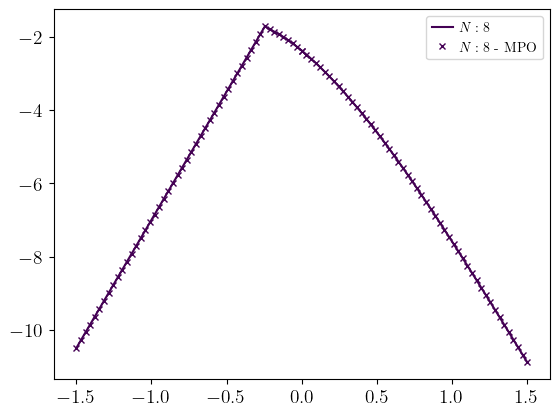

In [70]:
from qs_mps.utils import create_sequential_colors

colors = create_sequential_colors(len(Ns))

i = 0
for energy, energy_mpo in zip(energies, energies_mpo):
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energy, color=colors[i], label=f"$N: {Ns[i]}$")
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), np.asarray(energy_mpo), marker='x', markersize=5, linestyle='', color=colors[i], label=f"$N: {Ns[i]}$ - MPO")
    # plt.plot(Jzs, energy, color=colors[i], label=f"N: {Ns[i]}")
    i += 1
plt.legend()

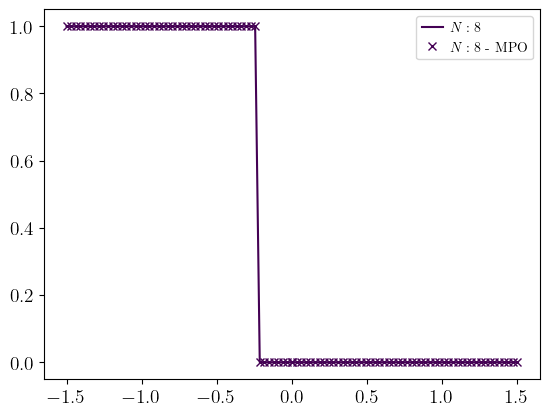

In [71]:
i = 0
for magnetization, magnetization_mpo in zip(magnetizations, magnetizations_mpo):
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), magnetization, color=colors[i], label=f"$N: {Ns[i]}$")
    plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), magnetization_mpo, marker='x', linestyle='', color=colors[i], label=f"$N: {Ns[i]}$ - MPO")
    # plt.plot(Jzs, energy, color=colors[i], label=f"N: {Ns[i]}")
    i += 1
plt.legend()

### DMRG

In [235]:
n = 8
eps = 0
chi = 81
energies_mps, entropies_mps, schmidt_vals_mps, times_mps = [], [], [], []
energies_hole, overlap_gs_hole = [], []
hole_state = guess_state_hole(n, 1)
for Jz in Jzs_n:
    print(f"N: {n}, J: {Jz:.3f}")
    mps = MPS(L=n, d=3, model="heis", chi=chi, J=1, h=Jz, eps=eps)
    mps._random_state(seed=np.random.randint(1,1001), chi=chi)
    mps.canonical_form()
    energy_mps, entropy_mps, schmidt_val_mps, time_mps = mps.DMRG(False, True, n_sweeps=4, where=n//2)
    energies_mps.append(energy_mps[-1])
    entropies_mps.append(entropy_mps)
    schmidt_vals_mps.append(schmidt_val_mps)
    times_mps.append(time_mps)

    mps_a = MPS(L=n, d=3, model="heis", chi=chi, J=1, h=Jz, eps=eps)
    mps_a.vector_to_mps(hole_state.toarray())
    mps_a.mpo()
    E_hole_mps = mps_a.mpo_first_moment().real
    mps_a.ancilla_sites = mps.sites.copy()
    overlap_mps = mps_a._compute_norm(site=1, mixed=True).real
    energies_hole.append(E_hole_mps)
    overlap_gs_hole.append(overlap_mps)


for Jz in Jzs_p:
    print(f"N: {n}, J: {Jz:.3f}")
    mps = MPS(L=n, d=3, model="heis", chi=chi, J=1, h=Jz, eps=eps)
    mps._random_state(seed=np.random.randint(1,1001), chi=chi)
    mps.canonical_form()
    energy_mps, entropy_mps, schmidt_val_mps, time_mps = mps.DMRG(False, True, n_sweeps=4, where=n//2)
    energies_mps.append(energy_mps[-1])
    entropies_mps.append(entropy_mps)
    schmidt_vals_mps.append(schmidt_val_mps)
    times_mps.append(time_mps)

    mps_a = MPS(L=n, d=3, model="heis", chi=chi, J=1, h=Jz, eps=eps)
    mps_a.vector_to_mps(hole_state.toarray())
    mps_a.mpo()
    E_hole_mps = mps_a.mpo_first_moment().real
    mps_a.ancilla_sites = mps.sites.copy()
    overlap_mps = mps_a._compute_norm(site=1, mixed=True).real
    energies_hole.append(E_hole_mps)
    overlap_gs_hole.append(overlap_mps)


N: 8, J: -1.500
Sweep n: 0

Sweep n: 1

N: 8, J: -1.469
Sweep n: 0

Sweep n: 1

N: 8, J: -1.439
Sweep n: 0

Sweep n: 1

N: 8, J: -1.408
Sweep n: 0

Sweep n: 1

N: 8, J: -1.378
Sweep n: 0

Sweep n: 1

N: 8, J: -1.347
Sweep n: 0

Sweep n: 1

N: 8, J: -1.316
Sweep n: 0

Sweep n: 1

N: 8, J: -1.286
Sweep n: 0

Sweep n: 1

N: 8, J: -1.255
Sweep n: 0

Sweep n: 1

N: 8, J: -1.224
Sweep n: 0

Sweep n: 1

N: 8, J: -1.194
Sweep n: 0

Sweep n: 1

N: 8, J: -1.163
Sweep n: 0

Sweep n: 1

N: 8, J: -1.133
Sweep n: 0

Sweep n: 1

N: 8, J: -1.102
Sweep n: 0

Sweep n: 1

N: 8, J: -1.071
Sweep n: 0

Sweep n: 1

N: 8, J: -1.041
Sweep n: 0

Sweep n: 1

N: 8, J: -1.010
Sweep n: 0

Sweep n: 1

N: 8, J: -0.980
Sweep n: 0

Sweep n: 1

N: 8, J: -0.949
Sweep n: 0

Sweep n: 1

N: 8, J: -0.918
Sweep n: 0

Sweep n: 1

N: 8, J: -0.888
Sweep n: 0

Sweep n: 1

N: 8, J: -0.857
Sweep n: 0

Sweep n: 1

N: 8, J: -0.827
Sweep n: 0

Sweep n: 1

N: 8, J: -0.796
Sweep n: 0

Sweep n: 1

N: 8, J: -0.765
Sweep n: 0

Sweep n: 1



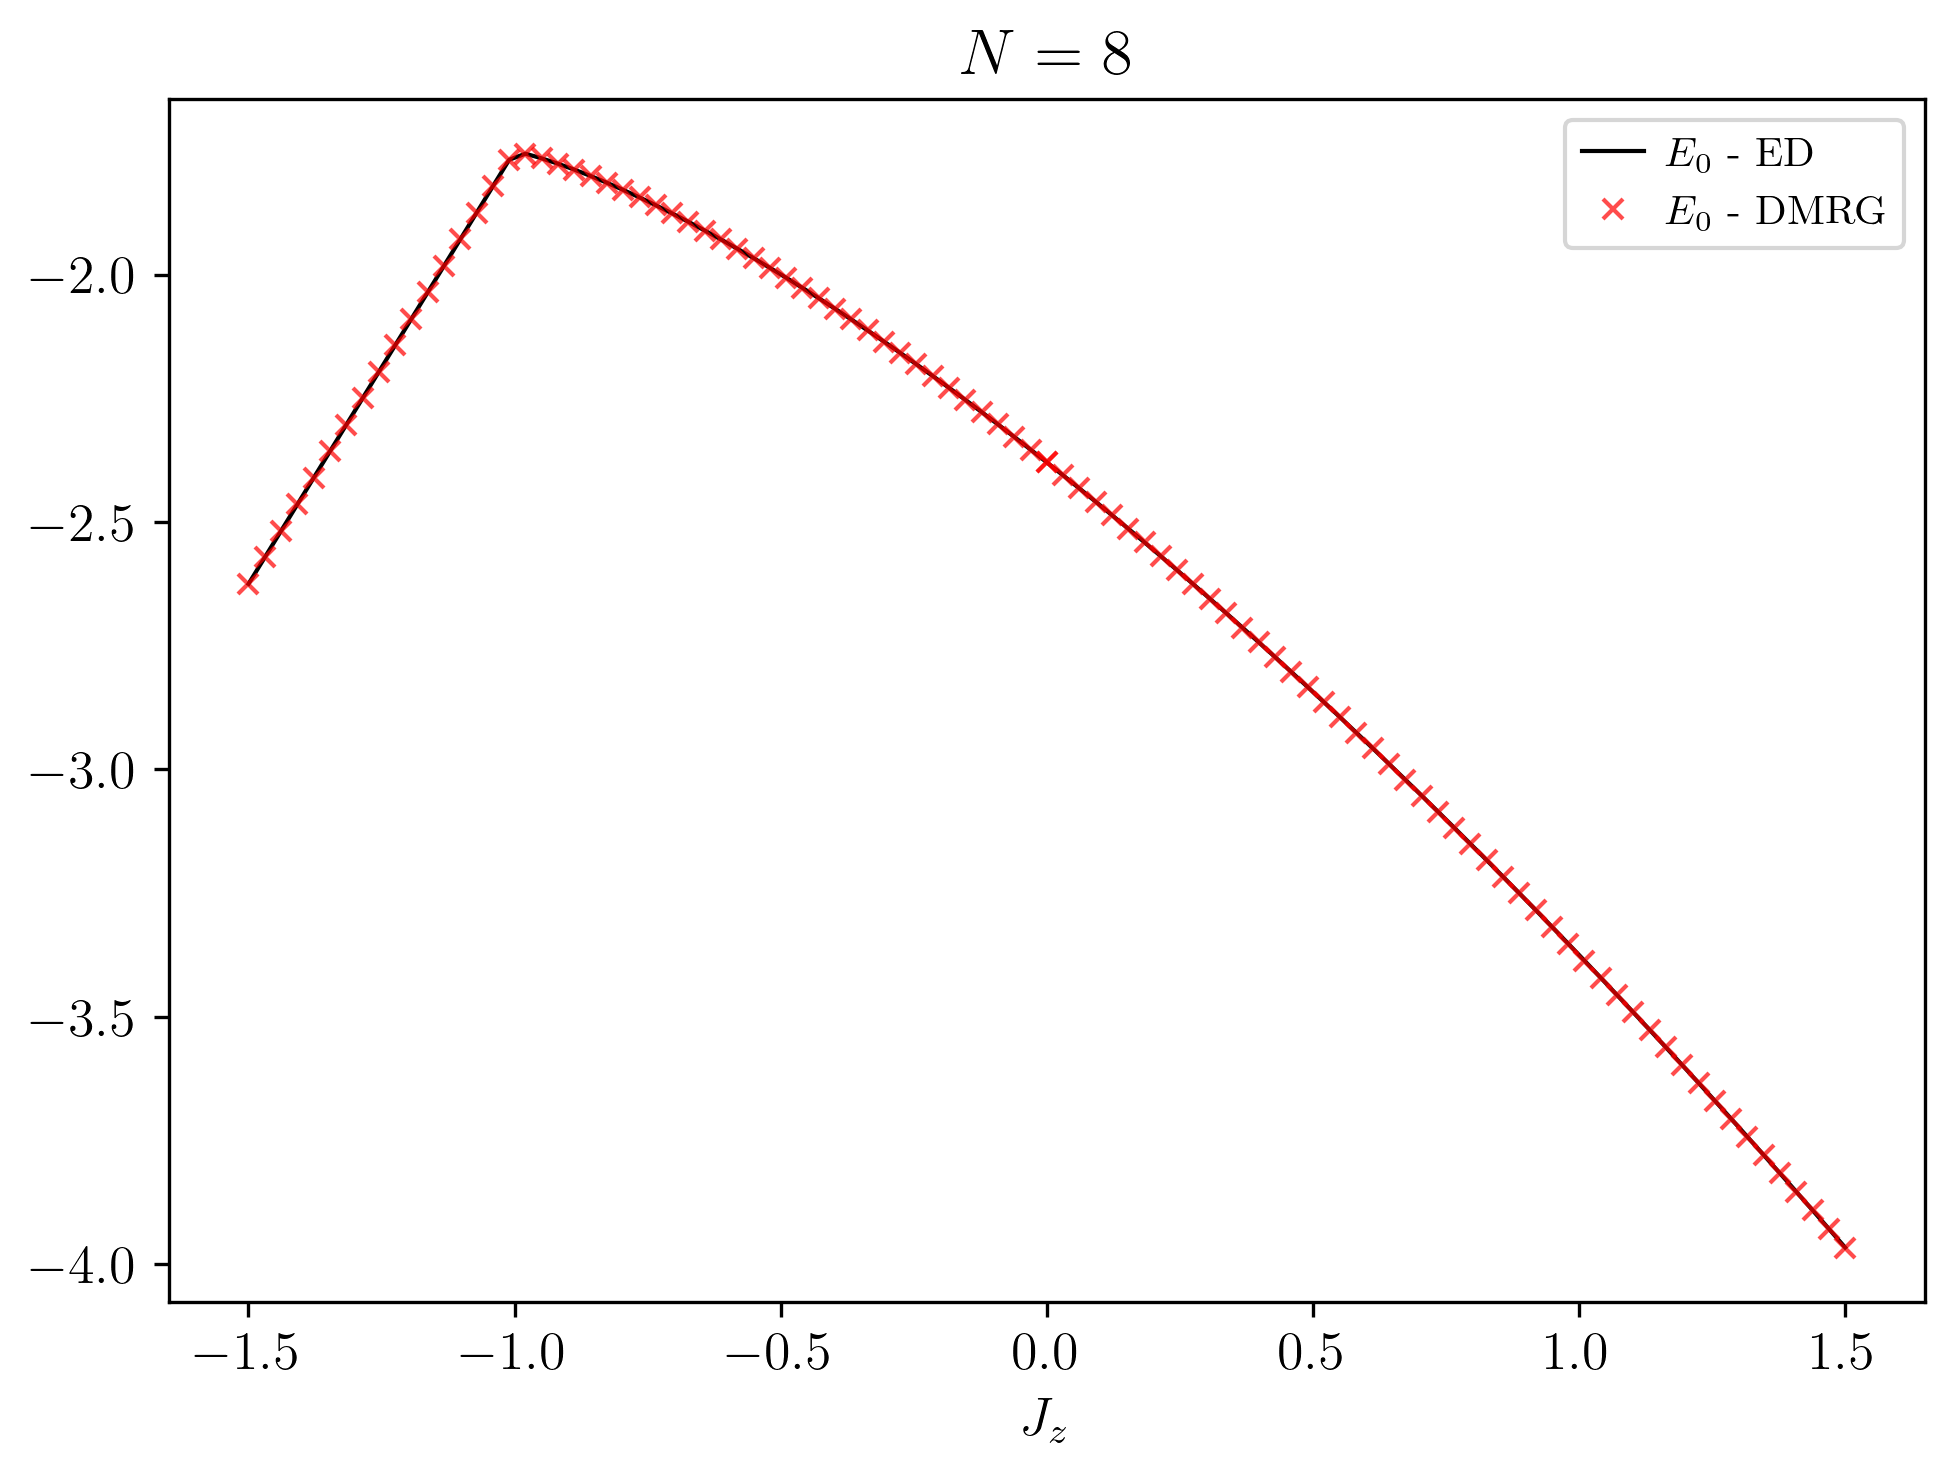

In [240]:
eps_gs = 0
L = N
path = "/Users/fradm/Desktop/projects/Fidelities_with_TN"

plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energies[0], color='k', linewidth=1, label=f"$E_0$ - ED")
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energies_mps, marker='x', markersize=5, linestyle='', color='r', alpha=0.7, linewidth=1, label=f"$E_0$ - DMRG")
plt.title(f"$N = {n}$")
plt.xlabel("$J_z$")
plt.legend()
plt.savefig(f"{path}/figures/energy_gs_ed_vs_dmrg_L_{L}_h_{h_i}-{h_f}_npoints_{npoints}_eps_{eps_gs}_chi_{chi}.pdf", dpi=300, format="pdf")


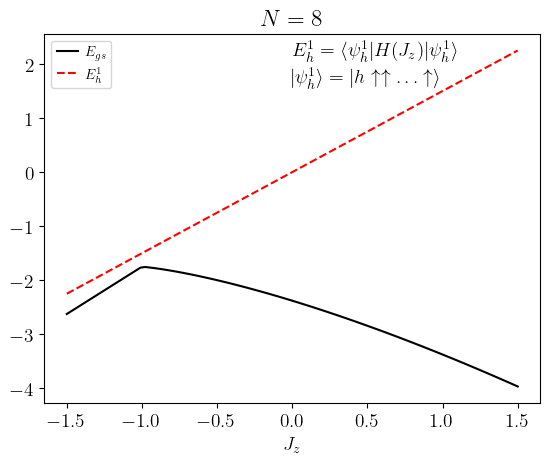

In [ ]:
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energies[0], color='k', label="$E_{gs}$")
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), energies_hole, linestyle='--', color='r', label="$E_h^1$")
plt.text(x=Jzs_p[0], y=max(energies_hole)-0.1, s=r"$E_h^1 = \langle \psi_h^1 | H (J_z) | \psi_h^1 \rangle$")
plt.text(x=Jzs_p[0], y=max(energies_hole)-0.6, s=r"$| \psi_h^1 \rangle = | h \uparrow \uparrow \dots \uparrow \rangle$")
plt.title(f"$N = {n}$")
plt.xlabel("$J_z$")
plt.legend()

<>:1: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:1: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
/var/folders/q8/7d5rxq0s6yv54h2hp2nhd2sr0000gq/T/ipykernel_97349/1633544712.py:1: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), np.abs(overlap_gs_hole), color='k', label="$\langle \psi_{gs} | \psi_h \\rangle$")


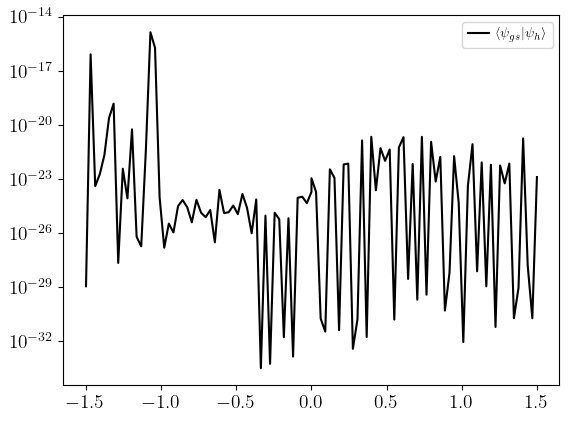

In [184]:
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), np.abs(overlap_gs_hole), color='k', label="$\langle \psi_{gs} | \psi_h \\rangle$")
plt.yscale('log')
plt.legend()

### larger MPS sim

In [241]:
n = 8
eps = 0
chi = 81
Jzs = np.linspace(-1.5,1.5,101)
energies_mps, entropies_mps, schmidt_vals_mps, times_mps = [], [], [], []
magnetization_mps, smagnetization_mps = [], []
hole_state = guess_state_hole(n, 1)
for Jz in Jzs:
    print(f"N: {n}, J: {Jz:.3f}")
    mps = MPS(L=n, d=3, model="heis", chi=chi, J=1, h=Jz, eps=eps)
    mps._random_state(seed=np.random.randint(1,1001), chi=chi)
    mps.canonical_form()
    energy_mps, entropy_mps, schmidt_val_mps, time_mps = mps.DMRG(False, True, n_sweeps=4, where=n//2)
    energies_mps.append(energy_mps[-1])
    entropies_mps.append(entropy_mps)
    schmidt_vals_mps.append(schmidt_val_mps)
    times_mps.append(time_mps)

    ### observables
    # magnetization_mps
    mps.mag_3()
    magnetization_mps.append(mps.mpo_second_moment().real)
    # magnetization_mps.append(mps.mpo_first_moment().real)
    # smagnetization_mps
    mps.mag_3(stag=True)
    smagnetization_mps.append(mps.mpo_second_moment().real)
    # smagnetization_mps.append(mps.mpo_first_moment().real)

N: 8, J: -1.500
Sweep n: 0

Sweep n: 1

N: 8, J: -1.470
Sweep n: 0

Sweep n: 1

N: 8, J: -1.440
Sweep n: 0

Sweep n: 1

N: 8, J: -1.410
Sweep n: 0

Sweep n: 1

N: 8, J: -1.380
Sweep n: 0

Sweep n: 1

N: 8, J: -1.350
Sweep n: 0

Sweep n: 1

N: 8, J: -1.320
Sweep n: 0

Sweep n: 1

N: 8, J: -1.290
Sweep n: 0

Sweep n: 1

N: 8, J: -1.260
Sweep n: 0

Sweep n: 1

N: 8, J: -1.230
Sweep n: 0

Sweep n: 1

N: 8, J: -1.200
Sweep n: 0

Sweep n: 1

N: 8, J: -1.170
Sweep n: 0

Sweep n: 1

N: 8, J: -1.140
Sweep n: 0

Sweep n: 1

N: 8, J: -1.110
Sweep n: 0

Sweep n: 1

N: 8, J: -1.080
Sweep n: 0

Sweep n: 1

N: 8, J: -1.050
Sweep n: 0

Sweep n: 1

N: 8, J: -1.020
Sweep n: 0

Sweep n: 1

N: 8, J: -0.990
Sweep n: 0

Sweep n: 1

N: 8, J: -0.960
Sweep n: 0

Sweep n: 1

N: 8, J: -0.930
Sweep n: 0

Sweep n: 1

N: 8, J: -0.900
Sweep n: 0

Sweep n: 1

N: 8, J: -0.870
Sweep n: 0

Sweep n: 1

N: 8, J: -0.840
Sweep n: 0

Sweep n: 1

N: 8, J: -0.810
Sweep n: 0

Sweep n: 1

N: 8, J: -0.780
Sweep n: 0

Sweep n: 1



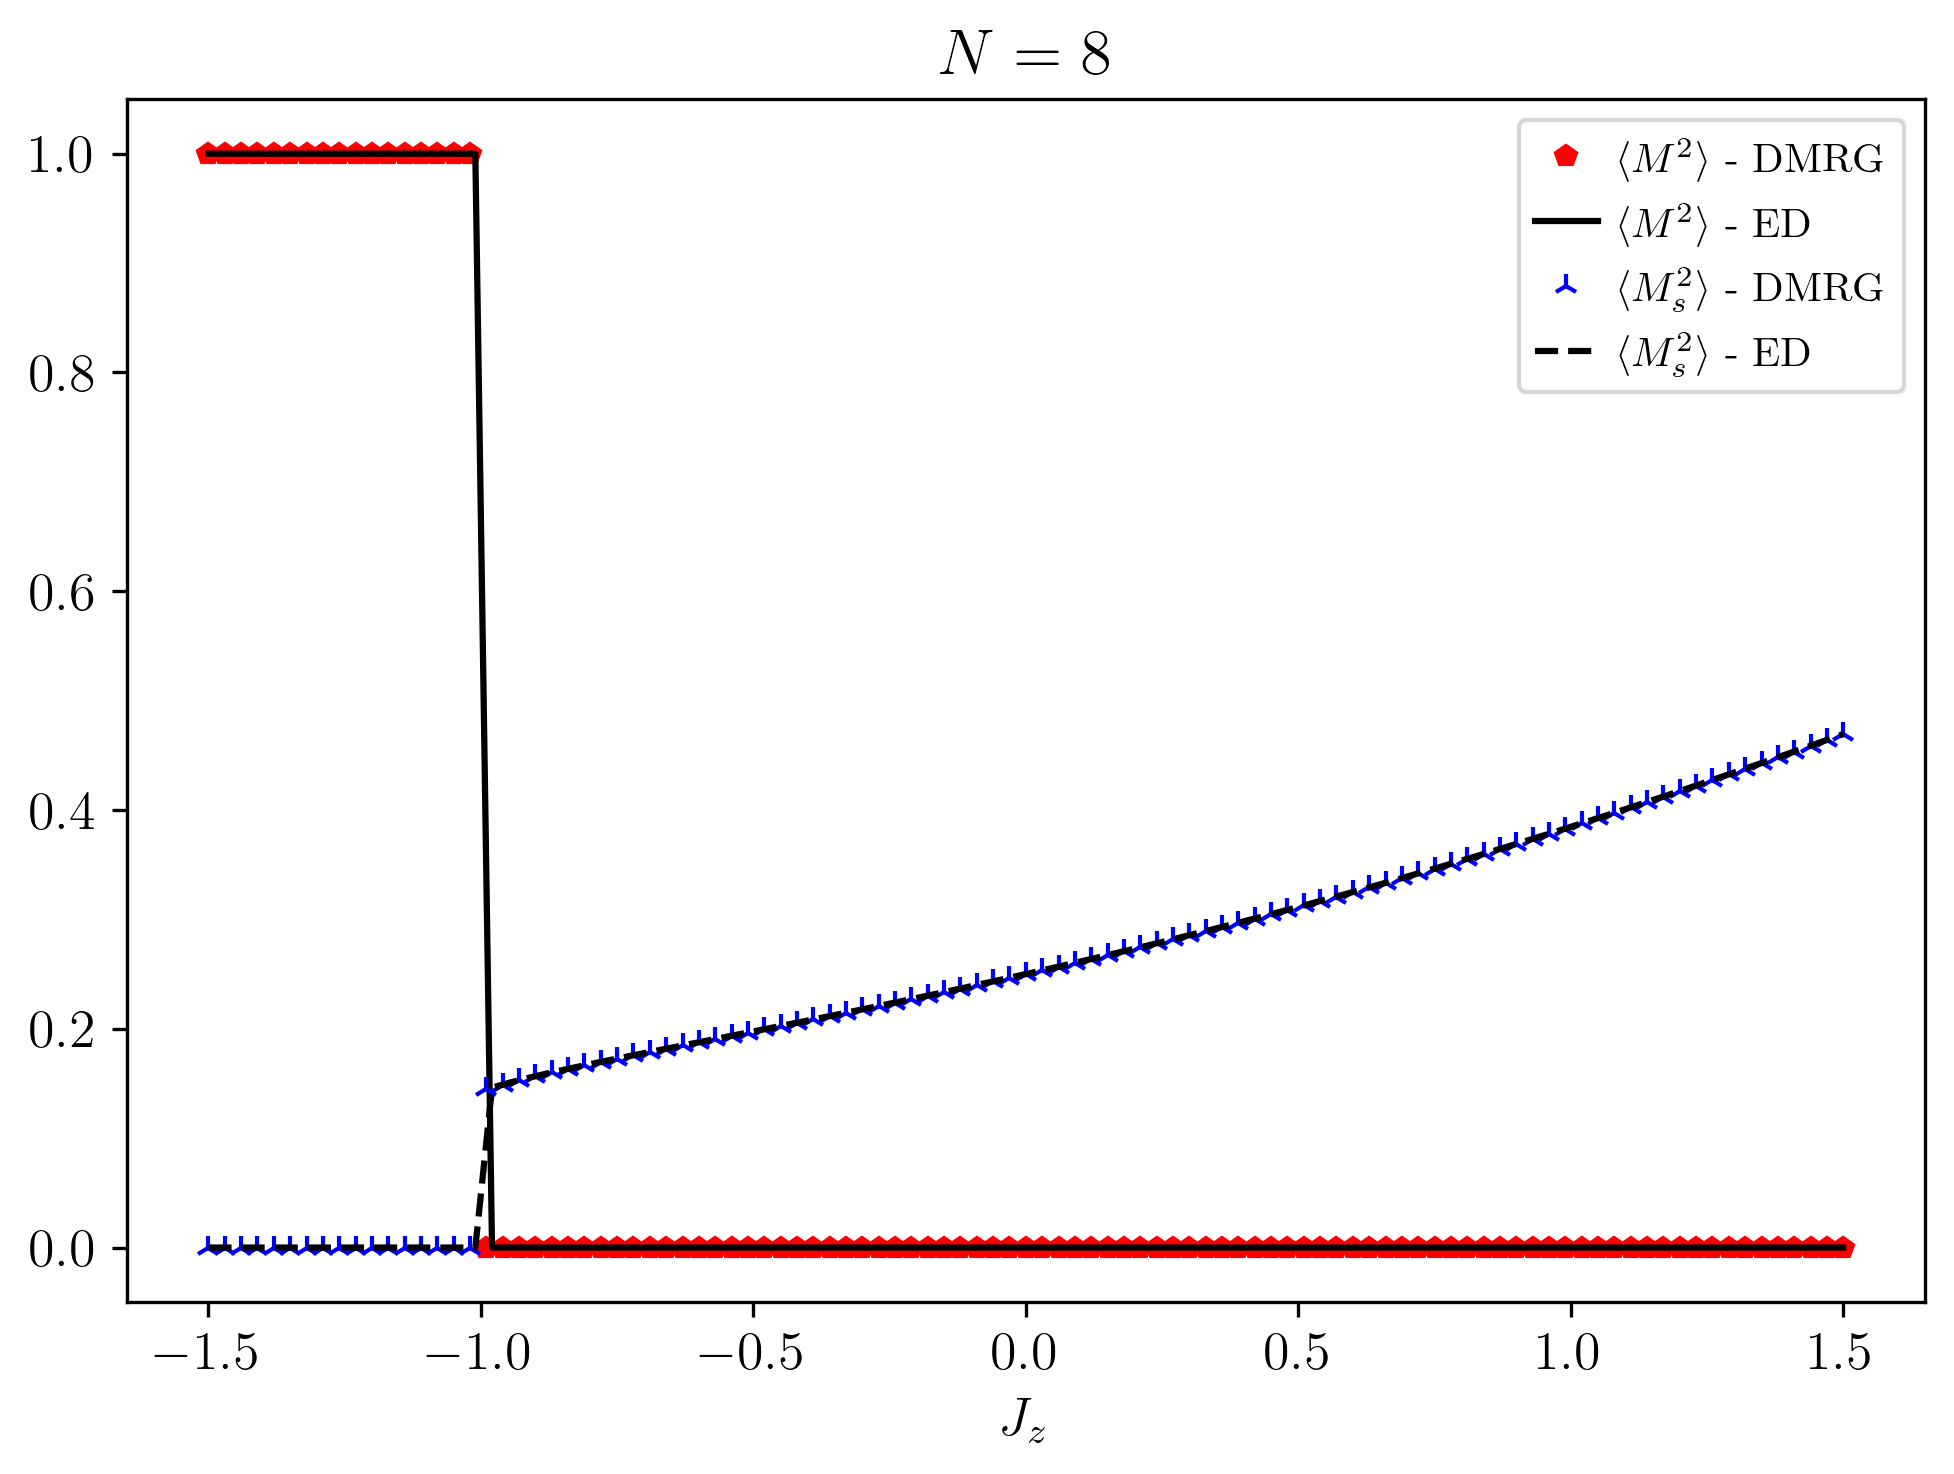

In [244]:
plt.plot(Jzs, np.asarray(magnetization_mps), color='r', marker='p', markersize=5, linestyle='', label=r"$\langle M^2 \rangle$ - DMRG")
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), 4*np.asarray(magnetizations)[0], color='k', label=r"$\langle M^2 \rangle$ - ED")
plt.plot(Jzs, np.asarray(smagnetization_mps), color='b', marker='2', linestyle='', label=r"$\langle M_s^2 \rangle$ - DMRG")
plt.plot(Jzs_n.tolist() + Jzs_p.tolist(), 4*np.asarray(smagnetizations)[0], linestyle='--', color='k', label=r"$\langle M_s^2 \rangle$ - ED")
plt.title(f"$N = {n}$")
plt.xlabel("$J_z$")
plt.legend()
plt.savefig(f"{path}/figures/mag_smag_ed_vs_dmrg_L_{L}_h_{h_i}-{h_f}_npoints_{npoints}_eps_{eps_gs}_chi_{chi}.pdf", dpi=300, format="pdf")
